In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import cv2 
import os 
import pickle 
import random
import shutil 
import uuid
# Image augmentation 
import albumentations as A

In [2]:
# Building model
import tensorflow as tf 
import tensorflow_io as tfio
from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.metrics import Recall, Accuracy, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler,  ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import mobilenet

In [3]:
# Directories Path 
IMAGE_SIZE = 224


# Augmented Path

augmented_train_path = 'D:\\train 39\\Data\\augmented_train'
augmented_test_path = 'D:\\train 39\\Data\\augmented_test'
augmented_validation_path = 'D:\\train 39\\Data\\augmented_validation'
model_path = 'D:\\train 39\\model'
history_path = 'D:\\train 39\\history'
dataset_path = 'D:\\train 39\\Dataset'

In [4]:
""" Run """
BATCH_SIZE = 32 
IMAGE_SIZE = 224
DATASET_DIR = 'D:\\train 39\\Dataset'
DATA_DIR = 'D:\\train 39\\Data'
TRAIN_DATA_DIR =  os.path.join(DATA_DIR, 'augmented_train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'augmented_test')
VALIDATION_DATA_DIR =  os.path.join(DATA_DIR, 'augmented_validation')
CLASSES = os.listdir(DATASET_DIR)
CLASSES

['Construction Helmet', 'No Construction Helmet', 'Not Construction Helmet']

In [5]:
""" Run """
for classes in CLASSES:
    count = len(os.listdir(os.path.join(DATASET_DIR,classes)))
    print(f'{classes} - {count}')

Construction Helmet - 3000
No Construction Helmet - 3000
Not Construction Helmet - 3000


In [6]:
""" Run """
print('train\ttest\tclass')

for classes in CLASSES:

    train_class_dir = os.path.join(TRAIN_DATA_DIR, classes)
    test_class_dir = os.path.join(TEST_DATA_DIR, classes)

    train_imges_count = len(os.listdir(train_class_dir))
    test_imges_count = len(os.listdir(test_class_dir))

    print(f'{train_imges_count}\t{test_imges_count}\t{classes} ')

train	test	class
12600	1800	Construction Helmet 
12600	1800	No Construction Helmet 
12600	1800	Not Construction Helmet 


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the batch size and target image size
batch_size = 32
target_size = (IMAGE_SIZE, IMAGE_SIZE)

# define data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./224,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./224)
val_datagen = ImageDataGenerator(rescale=1./224)

train_generator = train_datagen.flow_from_directory(augmented_train_path,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = train_datagen.flow_from_directory(augmented_test_path,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(augmented_validation_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode='categorical')
train_generator.class_indices

Found 37800 images belonging to 3 classes.
Found 5400 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


{'Construction Helmet': 0,
 'No Construction Helmet': 1,
 'Not Construction Helmet': 2}

In [8]:
x = train_generator.next()
image_shape = x[0].shape[1:]
f'Image shape {x[0].shape[1:]}'

'Image shape (224, 224, 3)'

In [9]:
# Load pre-trained CNN model
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=image_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# # Create a new model on top
inputs = tf.keras.Input(shape=image_shape)

# Add new classification layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(CLASSES), activation='softmax')(x)

# Create new model with VGG16 base and new classification layers
model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
checkpoint = ModelCheckpoint(filepath='ConstructionHelmet224.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
log_csv = CSVLogger('csv-filesConstructionHelmet_logs_MobileNetNew224.csv', separator=',', append=False)

callbacks = [
    checkpoint, 
    early_stop, 
    log_csv,
]
history = model.fit(train_generator,    
                    epochs=12,
                    verbose=True,
                    validation_data=val_generator,
                    callbacks = callbacks)

Epoch 1/12
1182/1182 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8969
Epoch 1: val_loss improved from inf to 0.14698, saving model to ConstructionHelmet224.hdf5
1182/1182 [==============================] - 9205s 8s/step - loss: 0.3915 - accuracy: 0.8969 - val_loss: 0.1470 - val_accuracy: 0.9494
Epoch 2/12
1182/1182 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9339
Epoch 2: val_loss improved from 0.14698 to 0.12243, saving model to ConstructionHelmet224.hdf5
1182/1182 [==============================] - 9068s 8s/step - loss: 0.1820 - accuracy: 0.9339 - val_loss: 0.1224 - val_accuracy: 0.9594
Epoch 3/12
1182/1182 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9418
Epoch 3: val_loss improved from 0.12243 to 0.12023, saving model to ConstructionHelmet224.hdf5
1182/1182 [==============================] - 9077s 8s/step - loss: 0.1554 - accuracy: 0.9418 - val_loss: 0.1202 - val_accuracy: 0.9550
Epoch 4/12
1182/1182

In [11]:
v_model = load_model('ConstructionHelmet224.hdf5') # palit
v_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [12]:
%pip install pydot
from tensorflow.keras.utils import plot_model
plot_model(v_model, to_file='cnn.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


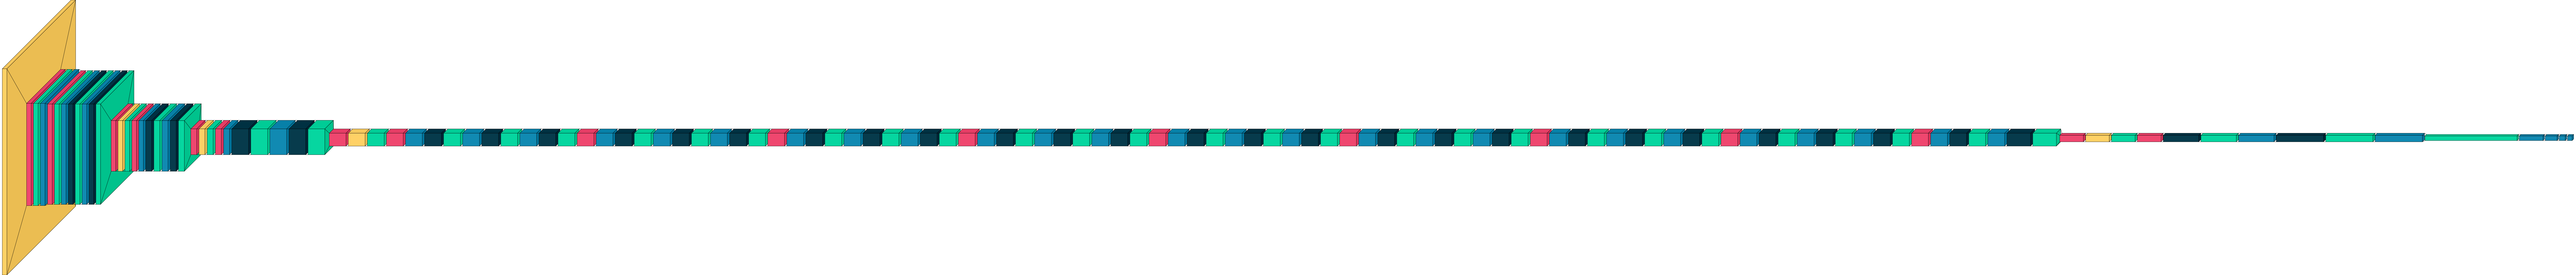

In [13]:
import visualkeras
visualkeras.layered_view(v_model).show() # display using your system viewer
visualkeras.layered_view(v_model, to_file='model.png').show() # write and show

visualkeras.layered_view(v_model)

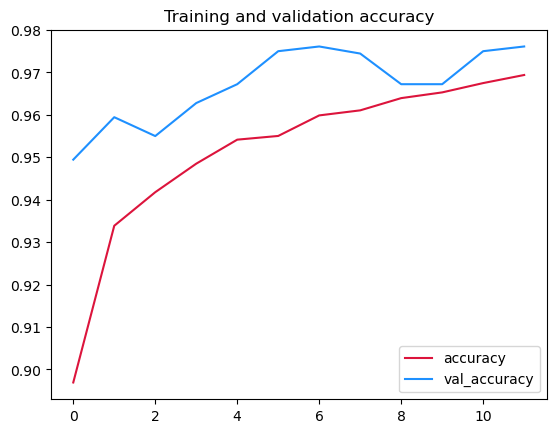

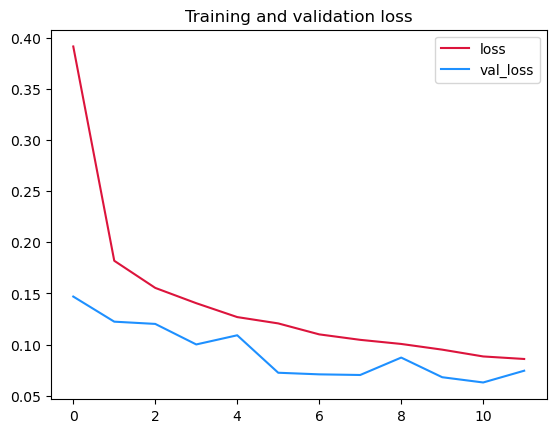

In [14]:
history = pd.read_csv('csv-filesConstructionHelmet_logs_MobileNetNew224.csv')
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'crimson')
plt.plot(epochs, val_acc, 'dodgerblue')
plt.title('Training and validation accuracy')
plt.legend(['accuracy','val_accuracy'], loc='lower right')
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'crimson')
plt.plot(epochs, val_loss, 'dodgerblue')
plt.title('Training and validation loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.show()

In [15]:
#Evaluating the model
score_test = v_model.evaluate(test_generator)
print("\nTest loss: ", score_test[0])
print("Test Accuracy: ", score_test[1])

169/169 [==============================] - 543s 3s/step - loss: 0.1213 - accuracy: 0.9583

Test loss:  0.12130741029977798
Test Accuracy:  0.9583333134651184


In [16]:
# evaluate the model based on validation data
score_test = model.evaluate(val_generator)
print("\nVal loss: ", score_test[0])
print("Val Accuracy: ", score_test[1])

57/57 [==============================] - 90s 2s/step - loss: 0.0745 - accuracy: 0.9761

Val loss:  0.07445894926786423
Val Accuracy:  0.976111114025116


In [17]:
# evaluate the model based on train data
score = model.evaluate(train_generator)
print("\nTrain loss: ", score[0])
print("Train Accuracy: ", score[1])

1182/1182 [==============================] - 3353s 3s/step - loss: 0.0796 - accuracy: 0.9724

Train loss:  0.07955048233270645
Train Accuracy:  0.9723544716835022


In [18]:
X,y = [],[]
for idx in CLASSES:
    path = os.path.join(TEST_DATA_DIR, str(idx))
    for img in tqdm(os.listdir(path)):  
        full_path = os.path.join(path,img )
        img = tf.keras.preprocessing.image.load_img(full_path, target_size=(224, 224))
        img_tensor = tf.keras.preprocessing.image.img_to_array(img) 
        img_tensor /= 224. 
        X.append(img_tensor)
        y.append(CLASSES.index(idx))


X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical(y)
X.shape, y.shape 

100%|██████████| 1800/1800 [02:27<00:00, 12.22it/s]


((5400, 224, 224, 3), (5400, 3))

169/169 [==============================] - 412s 2s/step


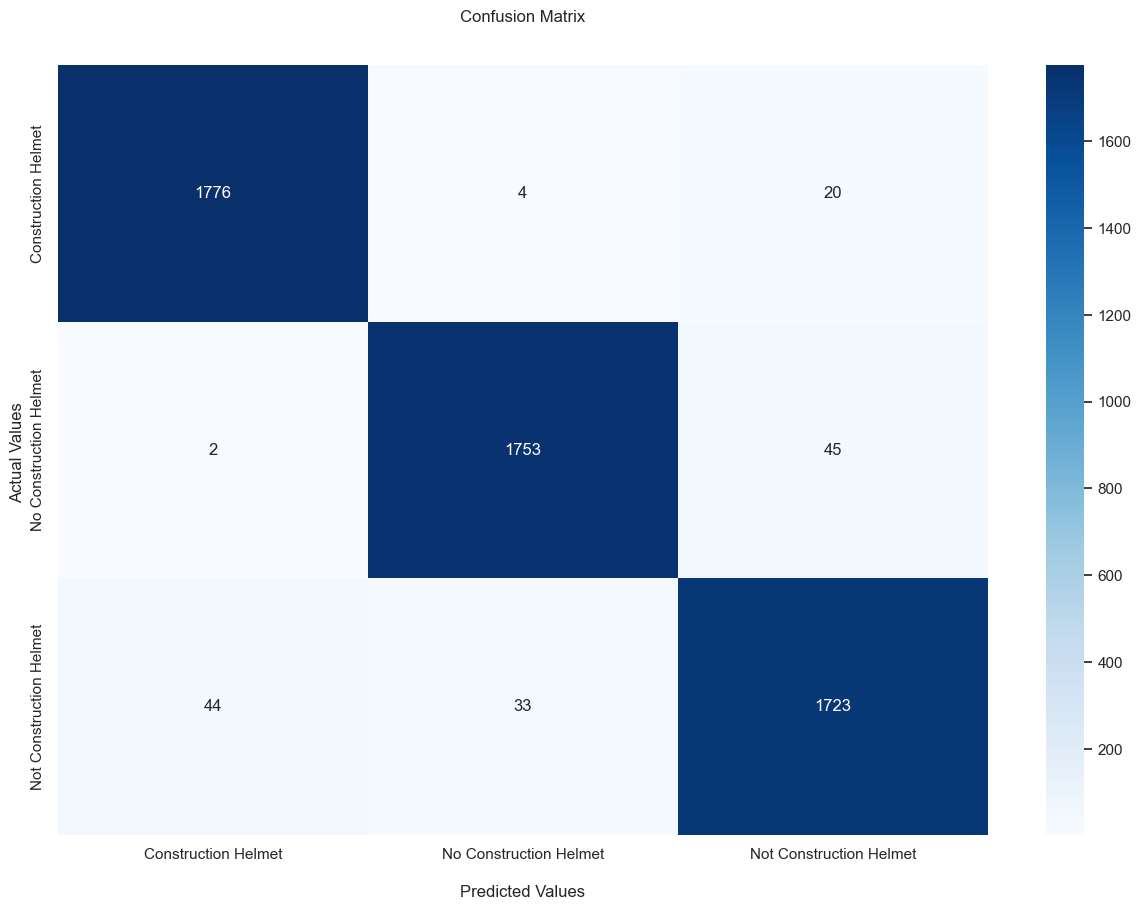

In [19]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

def conf_mat(y , model, title ):

    actual_y = [ np.argmax(i) for i in y]
    preds_y =  [ np.argmax(i) for i in model.predict(X)] 
    conf_mat = confusion_matrix(actual_y , preds_y)

    plt.figure(figsize=(15,10))
    df_cm = pd.DataFrame(conf_mat, CLASSES,  CLASSES)

    sns.set(font_scale=1)
    ax = sns.heatmap(df_cm , annot=True, cmap='Blues', fmt='g')

    ax.set_ylabel('Actual Values ');
    ax.set_xlabel('\nPredicted Values')
    ax.set_title(f'{title}\n\n')

conf_mat( y, v_model, 'Confusion Matrix')

In [20]:
from sklearn.metrics import classification_report

print(' Helmet Detection and Classification Model')
preds = v_model.predict(X)
print( classification_report(np.argmax(y, axis=1) , np.argmax(preds, axis=1) , target_names=CLASSES) )

 Helmet Detection and Classification Model
169/169 [==============================] - 278s 2s/step
                         precision    recall  f1-score   support

    Construction Helmet       0.97      0.99      0.98      1800
 No Construction Helmet       0.98      0.97      0.98      1800
Not Construction Helmet       0.96      0.96      0.96      1800

               accuracy                           0.97      5400
              macro avg       0.97      0.97      0.97      5400
           weighted avg       0.97      0.97      0.97      5400

